In [51]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report


In [52]:
# Load the annotated dataset
dataset = pd.read_csv('tai.csv')


In [53]:
dataset

,label,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x29,y29,x30,y30,x31,y31,x32,y32,x33,y33
0,Tame,259,120,267,108,271,108,275,108,251,...,123,595,489,597,126,606,522,610,109,626
1,Bow-Arrow,207,82,210,78,211,78,213,78,209,...,177,242,281,246,184,251,273,254,159,253
2,Bow-Arrow,233,85,241,73,246,72,251,71,230,...,133,501,499,505,147,520,478,520,82,526
3,Bow-Arrow,352,124,346,114,345,114,344,114,346,...,116,409,391,409,101,411,454,406,123,433
4,Bow-Arrow,174,179,181,165,184,165,187,165,179,...,89,636,643,662,111,673,640,691,32,668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Sitting,593,347,596,327,600,325,604,323,592,...,751,634,646,564,758,614,611,592,791,674
57,Sitting,304,119,302,99,302,99,302,99,294,...,352,546,88,521,346,575,106,574,457,587
58,Sitting,277,83,284,64,287,63,290,62,282,...,531,527,256,578,548,498,160,589,554,589
59,Taijiquan,389,116,398,100,402,100,408,101,381,...,272,680,461,680,277,691,479,731,267,735


In [54]:
# Apply stripping function to all elements in the DataFrame

dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\john\AppData\Local\Temp\ipykernel_11552\4251743574.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)


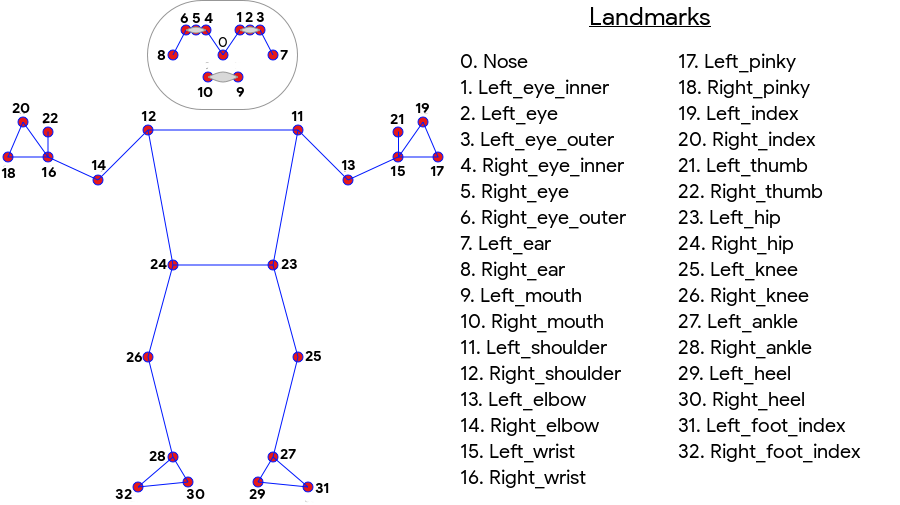

In [55]:
from IPython.display import Image

Image(filename='33 landmarks.png') 

In [56]:
# Define a function to calculate the angle between three keypoints
def get_angle(row, keypoint_1, keypoint_2, keypoint_3):
    # Extract the x and y coordinates of the keypoints
    a = np.array([row['x' + str(keypoint_1)], row['y' + str(keypoint_1)]])  # First
    b = np.array([row['x' + str(keypoint_2)], row['y' + str(keypoint_2)]])  # Mid
    c = np.array([row['x' + str(keypoint_3)], row['y' + str(keypoint_3)]])  # End

    # Calculate the vectors between the keypoints
    ba = a - b
    bc = c - b

    # Calculate the cosine of the angle
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Calculate the angle in degrees
    angle = math.degrees(np.arccos(cosine_angle))

    # Ensure the angle is between 0 and 180 degrees
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# Define the list of keypoints you want to calculate angles for
keypoints = [11, 12, 23, 24, 25, 26, 27, 28]

# Apply the get_angle function to your DataFrame for each combination of keypoints
dataset['angle'] = dataset.apply(lambda row: get_angle(row, keypoints[0], keypoints[1], keypoints[2]), axis=1)
# Repeat the above line for other combinations of keypoints if needed.


In [84]:
# Get the number of rows and columns
num_rows, num_columns = dataset.shape

print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')

Number of rows: 61
Number of columns: 68


In [58]:
unique_values = dataset['label'].unique()
print(unique_values)

['Tame' 'Bow-Arrow' 'False Stance' 'Four-Six' 'Golden Rooster'
 'Horse Stance' 'Sitting' 'Taijiquan']


In [59]:
# Extract labels
labels = dataset["label"]

# Extract keypoint data including the 'angle' column
keypoints = dataset.drop("label", axis=1).values


In [60]:
# Normalize the keypoints (optional but often helpful)
keypoints = (keypoints - keypoints.mean()) / keypoints.std()

In [61]:
# Convert labels to numerical values (you may need to encode them appropriately)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


Split the dataset into training and testing sets

In [62]:
#dataset = dataset.filter(['angle', 'label'])

# Setup the testing and training sets
#X = dataset.drop('label', axis=1)
#y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(keypoints, labels, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(48, 67) (48,) (13, 67) (13,)


Define the RNN model

In [63]:
class KeypointRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(KeypointRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Define model hyperparameters
input_size = 67  # The number of features in your dataset
hidden_size = 64  # Number of units in the RNN layer
num_layers = 1  # Number of RNN layers
num_classes = 8

# Initialize the model
model = KeypointRNN(input_size, hidden_size, num_layers, num_classes)



Prepare data for training

In [64]:
# Convert the training data to PyTorch tensors
X_train = torch.Tensor(X_train).view(-1, 1, input_size)
y_train = torch.LongTensor(y_train)

# Create a DataLoader for training
train_data = TensorDataset(X_train, y_train)
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Define loss function and optimizer

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Train the model

In [66]:
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}")

print("Training complete!")


Epoch [1/10] Loss: 2.1238
Epoch [2/10] Loss: 2.0324
Epoch [3/10] Loss: 1.9433
Epoch [4/10] Loss: 1.8568
Epoch [5/10] Loss: 1.7732
Epoch [6/10] Loss: 1.6930
Epoch [7/10] Loss: 1.6163
Epoch [8/10] Loss: 1.5435
Epoch [9/10] Loss: 1.4747
Epoch [10/10] Loss: 1.4102
Training complete!


Evaluate the model

In [74]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    X_test = torch.Tensor(X_test).view(-1, 1, input_size)
    y_test = torch.LongTensor(y_test)
    outputs = model(X_test)
    
    _, predicted = torch.max(outputs, 1)
    y_true = y_test.numpy()
    y_pred = predicted.numpy()

    correct = (y_true == y_pred).sum()  # Count the number of correct predictions
    total = len(y_test)  # Total number of predictions

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

model.train()  # Set the model back to training mode


Test Accuracy: 53.85%


KeypointRNN(
  (rnn): RNN(67, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [75]:
unique_classes = len(np.unique(y_true))  # Assuming y_true is a NumPy array


In [76]:
class_names = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7"]
class_report = classification_report(y_true, y_pred, target_names=class_names)


c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Classification Report:
              precision    recall  f1-score   support

      Class1       0.00      0.00      0.00         1
      Class2       0.00      0.00      0.00         1
      Class3       0.00      0.00      0.00         1
      Class4       0.58      1.00      0.74         7
      Class5       0.00      0.00      0.00         1
      Class6       0.00      0.00      0.00         1
      Class7       0.00      0.00      0.00         1

    accuracy                           0.54        13
   macro avg       0.08      0.14      0.11        13
weighted avg       0.31      0.54      0.40        13

[[0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 7 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]


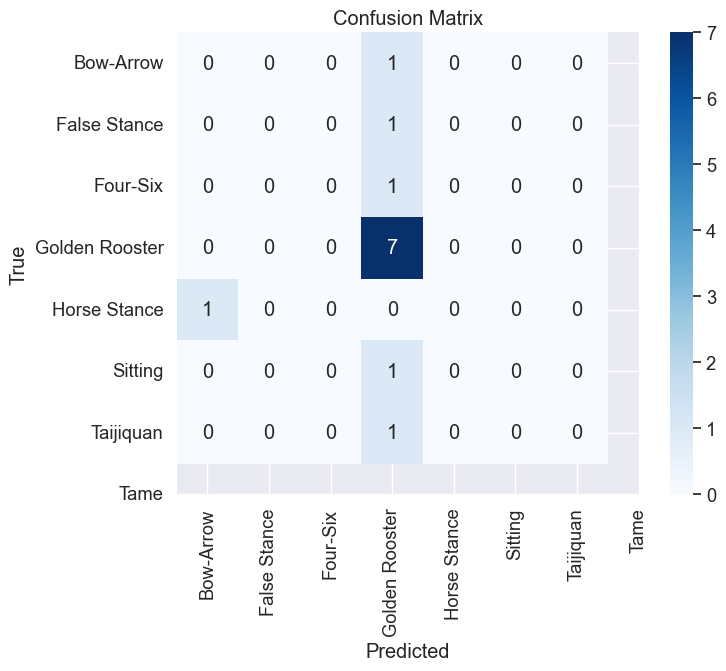

In [77]:
# Print the classification report
print("Classification Report:")
print(class_report)

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)

# Plot the confusion matrix with a colorbar
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, square=True)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()


In [78]:
from sklearn.metrics import matthews_corrcoef

# Assuming you have your confusion matrix as 'confusion_mat'
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)


Matthews Correlation Coefficient (MCC): 0.11470786693528089


In [79]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds (K)
n_splits = 5  # You can adjust this as needed

# Initialize a list to store accuracy scores for each fold
cross_val_scores = []

# Initialize the Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define loss function and optimizer for your model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in stratified_kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Convert NumPy arrays to PyTorch tensors
    X_train_fold = torch.Tensor(X_train_fold).view(-1, 1, input_size)
    y_train_fold = torch.LongTensor(y_train_fold)

    # Train your model on the training fold
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation fold
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        X_val_fold = torch.Tensor(X_val_fold).view(-1, 1, input_size)
        y_val_fold = torch.LongTensor(y_val_fold)
        outputs = model(X_val_fold)

        _, predicted = torch.max(outputs, 1)
        y_pred = predicted.numpy()

        accuracy = accuracy_score(y_val_fold, y_pred)
        cross_val_scores.append(accuracy)

# Calculate and print the average accuracy across all folds
avg_accuracy = np.mean(cross_val_scores)
print(f"Average Accuracy across {n_splits}-Fold Cross-Validation: {avg_accuracy * 100:.2f}%")


c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Accuracy across 5-Fold Cross-Validation: 90.00%


In [80]:
# Specify the file path where you want to save the model
model_path = "keypoint_rnn_model.pth"

# Save the model's state dictionary to the specified file
torch.save(model.state_dict(), model_path)
